# Preamble
This is my second data science project and my first competition here on Kaggle. In first place I will analyse the single features. Therefore it starts with a null-value analysis and the restoration of missing data. This includes the creation of new features as well. Right after that, there will be a feature distribution as well as a survivor distribution to get a closer view of the dataset. For exercise, I have tried a lot around with Matplotlib to visualize several different charts. This sometimes ends in a lot of lines of code which I had to hide to not overload this notebook. In the end of this notebook there will be a crossvaildation of the trained model as well as the execution on the test dataset.

**I am looking forward to your feedback and comments. If you like my work please upvote it.**


# Import and Preparation

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns

# scipy.special for sigmoid function
import scipy.special

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'gender_submission.csv', 'test.csv']


In [2]:
df_train = pd.read_csv('../input/train.csv', index_col='PassengerId')
df_test = pd.read_csv('../input/test.csv', index_col='PassengerId')
df_gender_sub = pd.read_csv("../input/gender_submission.csv", index_col='PassengerId')

In [3]:
# Storing the target separately
Survived = df_train.loc[:,'Survived']
df_train = df_train.drop(['Survived'], axis=1).copy()

# Saving index for train test split 
train_index = df_train.index
test_index = df_test.index

# Concate the two datasets
df_all = pd.concat([df_train, df_test])

# dont needed anymore
##del df_train
##del df_test

# Missing Values

In [4]:
# Function for nullanalysis
def nullAnalysis(df):
    tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})

    tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
    tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
    return tab_info

In [5]:
# Show the null values
nullAnalysis(df_all)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
column type,int64,object,object,float64,int64,int64,object,float64,object,object
null values (nb),0,0,0,263,0,0,0,1,1014,2
null values (%),0,0,0,20.0917,0,0,0,0.0763942,77.4637,0.152788


## Age

In [6]:
# First 10 datarows where age is null
df_all[df_all.loc[:,'Age'].isnull()].head(10)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
18,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
20,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
27,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
29,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
30,3,"Todoroff, Mr. Lalio",male,NaN,0,0,349216,7.8958,NaN,S
32,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C
33,3,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q
37,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,NaN,C


In [7]:
# Average age overall
print("Average age of a passengers: ", round(df_all.loc[:,'Age'].agg('mean'),0))

Average age of a passengers:  30.0


### Average Age per Class

In [8]:
# Average age per class
df_all.groupby('Pclass')['Age'].agg('mean')

Pclass
1    39.159930
2    29.506705
3    24.816367
Name: Age, dtype: float64

We will use the average age of the corresponding class to fill the missing passenger ages. This would be the best fit for that problem.

In [9]:
# Setting the average age of each class for the missing values inside the corresponding class
df_all.loc[(df_all['Age'].isnull()) & (df_all['Pclass'] == 1), ['Age']] = round(df_all.groupby('Pclass')['Age'].agg('mean')[1],0)
df_all.loc[(df_all['Age'].isnull()) & (df_all['Pclass'] == 2), ['Age']] = round(df_all.groupby('Pclass')['Age'].agg('mean')[2],0)
df_all.loc[(df_all['Age'].isnull()) & (df_all['Pclass'] == 3), ['Age']] = round(df_all.groupby('Pclass')['Age'].agg('mean')[3],0)

## Fare


In [10]:
df_all[df_all['Fare'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


Only one passenger has not payed his Ticket, or is even not recorded. To fill the gab I will use the mean ticket price for his third class ticket: 13.30 

In [11]:
df_all.groupby('Pclass', as_index=False)['Fare'].agg('mean')

,Pclass,Fare
0,1,87.508992
1,2,21.179196
2,3,13.302889


In [12]:
# Setting Fare to mean fare of pclass
df_all.loc[1044,['Fare']] = 13.30

## Cabin

In [13]:
# Count all Cabins with NaN data
print("Count of cabins with nan data: ")
df_all.loc[(df_all.loc[:,'Cabin'].isnull()) == True]['Name'].count()

Count of cabins with nan data: 


1014

The *Cabin* situation looks pretty bad. From the 1309 data points are only roundabout 300 filled with *Cabin* information, the other 1000 data points are empty. I assumed with the cabin information we could rather conclude on a passengers survival. I don't want to use the fillna() - method with this sparely filled feature, that would not make any sense and will probably affect my results badly.  Let's look into the *Cabin* distribution compared to the *Pclass*.

### Cabin and Pclass Distribution

In [14]:
# Group by Pclasses
df_all.groupby('Pclass').agg('count')[['Name','Cabin']]

,Name,Cabin
Pclass,,
1,323,256
2,277,23
3,709,16


The roundabout 300 filled examples for the *Cabin* information are fairly one-sided distributed to the first class (*Pclass*). The *Name* shows the total distribution for the cabin class, so 256 passengers of 323 first class passengers have a *Cabin* information available. Only 39 *Cabin* values in total are filled in the second and third class (*Pclass*). A comparison to the number of passengers does not make it better, there are 709 passengers in the third, 277 in the second class and 323 in the first class. 
The completeness of the data in relation to the number of passengers per class is as follows:

In [15]:
(df_all.groupby('Pclass').agg('count')['Cabin'] / df_all.groupby('Pclass').agg('count')['Name'])*100

Pclass
1    79.256966
2     8.303249
3     2.256700
dtype: float64

It clearly shows that the second and third class are sparsely filled in comparison to their passenger's count. The first class looks with nearly 80% pretty good. We could consider applying the **fillNa** only to the first class and using different methods for the second and third class.

While analysing the *Cabin* feature I realize there are sometimes multiple values inside the *Cabin* feature. The following table shows these multiple *Cabin* values:

In [16]:
df_all[df_all['Cabin'].str.contains(' ', regex=False) == True].sort_values(by='Cabin')

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1235,1,"Cardeza, Mrs. James Warburton Martinez (Charlo...",female,58.00,0,1,PC 17755,512.3292,B51 B53 B55,C
873,1,"Carlsson, Mr. Frans Olof",male,33.00,0,0,695,5.0000,B51 B53 B55,S
680,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.00,0,1,PC 17755,512.3292,B51 B53 B55,C
1264,1,"Ismay, Mr. Joseph Bruce",male,49.00,0,0,112058,0.0000,B52 B54 B56,S
1034,1,"Ryerson, Mr. Arthur Larned",male,61.00,1,3,PC 17608,262.3750,B57 B59 B63 B66,C
956,1,"Ryerson, Master. John Borie",male,13.00,2,2,PC 17608,262.3750,B57 B59 B63 B66,C
916,1,"Ryerson, Mrs. Arthur Larned (Emily Maria Borie)",female,48.00,1,3,PC 17608,262.3750,B57 B59 B63 B66,C
312,1,"Ryerson, Miss. Emily Borie",female,18.00,2,2,PC 17608,262.3750,B57 B59 B63 B66,C
743,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.00,2,2,PC 17608,262.3750,B57 B59 B63 B66,C


There is a way to split the string values easily but the information gain from the 41 examples in comparison to the roundabout 1000 missing values are pretty low:

In [17]:
# Creating a data frame for the Cabin values to split multiple values into seperate columns
df_cabin_expand = df_all.loc[:,'Cabin'].str.split(' ', expand=True)

# Group all doubled values by the first value
df_cabin_expand[df_cabin_expand.loc[:,1].isnull() == False].groupby([0]).count()

,1,2,3
0,,,
B51,3,3,0
B52,1,1,0
B57,5,5,5
B58,3,0,0
B82,1,0,0
B96,4,0,0
C22,4,0,0
C23,6,6,0
C55,2,0,0


The *Cabin* feature will be dropped at least. There is no way of restoring the information from this column, the duplicate values are not enough to restore all missing values and the other features do not supply enough information to restore this based of them.

## Embark
The *Embark* feature has two null values. For this small amount of missing values, I will use the fillna-function to fill the gaps.

In [18]:
df_all[df_all['Embarked'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [19]:
# Fill the two missing Embarked features by using the next valid value
df_all['Embarked'] = df_all['Embarked'].fillna(method='bfill')

# Feature Creation

## Salutation
With analyzing the *Cabin* feature I realized there exist different salutations in the passengers *Name* feature. The string split function will be useful here, mentioned in the *Cabin* feature analysis. The values differ among others as follows:

In [20]:
# Split Name feature strings into several columns
df_name_salutation = df_all.loc[:,'Name'].str.split(' ', expand=True).copy()
df_name_salutation.groupby(1).count()

,0,2,3,4,5,6,7,8,9,10,11,12,13
1,,,,,,,,,,,,,
"Billiard,",3,3,3,3,0,0,0,0,0,0,0,0,0
"Brito,",1,1,1,1,0,0,0,0,0,0,0,0,0
Capt.,1,1,1,0,0,0,0,0,0,0,0,0,0
"Carlo,",2,2,2,1,1,0,0,0,0,0,0,0,0
Col.,4,4,3,0,0,0,0,0,0,0,0,0,0
"Cruyssen,",1,1,1,0,0,0,0,0,0,0,0,0,0
Don.,1,1,1,0,0,0,0,0,0,0,0,0,0
Dr.,8,8,4,0,0,0,0,0,0,0,0,0,0
"Gordon,",2,2,2,2,2,2,1,0,0,0,0,0,0


Here is still something to clean but you can clearly see, that the most values in the split column "1" refers to the passenger's salutation. Moreover, I recognized that the salutations strings always ends with a dot.:

- Capt. - Captain
- Col. - Colonel
- Don. - Don
- Dr. - Doctor
- Major.
- Master. - "a way of addressing politely a boy ... too young to be called 'Mister'." - *Leslie Dunkling*  
- Miss. 
- Mlle. - Mademoiselle
- Mme. - Madame
- Mr.
- Mrs.
- Ms.
- Countess.
- ...

Next I will retriev the single salutations from column *"1"* and *"2"* based on the string value "." (dot) and concatenate the two columns to one salutation column and append these to the main dataframe. 

In [21]:
# Extract Salutation from every column based on the '.'
df_newsal_1 = df_name_salutation[df_name_salutation[1].str.contains('.', regex=False)][1]
df_newsal_2 = df_name_salutation[df_name_salutation[2].str.contains('.', regex=False)][2]
df_newsal_3 = df_name_salutation[(df_name_salutation[3].isnull() == False) & (df_name_salutation[3].str.contains('.', regex=False))][3]

# Rename column for append 
df_newsal_2 = df_newsal_2.rename(1)
df_newsal_3 =  df_newsal_3.rename(1)

# Append both salutations results to one column and rename them
df_newsal = df_newsal_1.append([df_newsal_2, df_newsal_3])
df_newsal = df_newsal.rename('Salutation')

# Concatenate them to the main dataframe
df_all = pd.concat([df_all,df_newsal],axis=1)

The following list shows all the salutation distribution. Nothing is leftover:

In [22]:
df_all.groupby('Salutation').count()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Salutation,,,,,,,,,,
Capt.,1,1,1,1,1,1,1,1,1,1
Col.,4,4,4,4,4,4,4,4,3,4
Countess.,1,1,1,1,1,1,1,1,1,1
Don.,1,1,1,1,1,1,1,1,0,1
Dona.,1,1,1,1,1,1,1,1,1,1
Dr.,8,8,8,8,8,8,8,8,4,8
Jonkheer.,1,1,1,1,1,1,1,1,0,1
Lady.,1,1,1,1,1,1,1,1,1,1
Major.,2,2,2,2,2,2,2,2,2,2


## Family
Creating a ***Family*** true / false information based on the count of SibSp and Parch.


In [23]:
# Create new feature Family true/false
df_all.loc[:,'Family'] = ((df_all['SibSp'] > 0) | (df_all['Parch'] > 0)).replace(True, 1, inplace=False)
df_all.loc[:,'Family'] = df_all.loc[:,'Family'].astype(int)

### Family Name Extraction

In [24]:
# Splitting the name feature into seperate strings
df_familynames = df_all.loc[:,'Name'].str.split(' ', expand=True).copy()

# Families with single last name
l_singleLastname = df_familynames[(df_familynames[0].str.contains(',', regex=False)==True)].index

# Families with double last name
l_doubleLastname = df_familynames[(df_familynames[0].str.contains(',', regex=False)==False) 
                                  & (df_familynames[1].str.contains(',', regex=False)==True)].index

# Families with double last name and more
l_doubleLastnameSpec = df_familynames[(df_familynames[0].str.contains(',', regex=False)==False) 
                                      & (df_familynames[1].str.contains(',', regex=False)==False) 
                                      & (df_familynames[2].str.contains(',', regex=False)==True)].index

# Create all last names for the single named, double named and multiple named passengers
df_singleLastname = df_familynames.loc[l_singleLastname,0]
df_doubleLastname = (df_familynames.loc[l_doubleLastname,0] 
                     + ' ' + df_familynames.loc[l_doubleLastname,1])
df_doubleLastnameSpec = (df_familynames.loc[l_doubleLastnameSpec,0] 
                         + ' ' + df_familynames.loc[l_doubleLastnameSpec,1] 
                         + ' ' + df_familynames.loc[l_doubleLastnameSpec,2])


# Rename column for append 
df_singleLastname = df_singleLastname.rename('Lastname')
df_doubleLastname = df_doubleLastname.rename('Lastname')
df_doubleLastnameSpec =  df_doubleLastnameSpec.rename('Lastname')

# Creating a Lastname column in initial dataframe
df_familynames['Lastname'] = df_singleLastname.append([df_doubleLastname, df_doubleLastnameSpec])


### Family Member Count

In [25]:
df_lastname_count = df_familynames.groupby('Lastname', as_index=False).count()

# dropping all columns except for the first one
df_lastname_count = df_lastname_count.drop([1,2,3,4,5,6,7,8,9,10,11,12,13], axis=1)
df_familynames = df_familynames.drop([0,1,2,3,4,5,6,7,8,9,10,11,12,13], axis=1)

# Joining the grouped by lastname counts to the PassengersId
df_familynames = df_familynames.join(df_lastname_count.set_index('Lastname'), on='Lastname')

#renaming column
df_familynames = df_familynames.rename(columns = {0: "Number_of_Familymembers"})

In [26]:
# Mergin the Lastnames and their family member count to original df
df_all = pd.merge(df_all , df_familynames, right_index=True, left_index=True)
# Removing the trailing comma
df_all['Lastname'] = df_all['Lastname'].str.rstrip(',')

Everyone who is travelling alone according to the ***Family*** feature, will be set with 1 for ***Number_of_Familymembers*** feature.

In [27]:
# Set Number_of_Familymembers = 0 when traveling alone
df_all.loc[df_all['Family'] == 0,'Number_of_Familymembers'] = 1 

# Feature Distribution

## Gender Distribution

In [28]:
# Gender distribution
df_all.groupby(['Parch']).agg('count')

,Pclass,Name,Sex,Age,SibSp,Ticket,Fare,Cabin,Embarked,Salutation,Family,Lastname,Number_of_Familymembers
Parch,,,,,,,,,,,,,
0,1002,1002,1002,1002,1002,1002,1002,205,1002,1002,1002,1002,1002
1,170,170,170,170,170,170,170,56,170,170,170,170,170
2,113,113,113,113,113,113,113,29,113,113,113,113,113
3,8,8,8,8,8,8,8,3,8,8,8,8,8
4,6,6,6,6,6,6,6,2,6,6,6,6,6
5,6,6,6,6,6,6,6,0,6,6,6,6,6
6,2,2,2,2,2,2,2,0,2,2,2,2,2
9,2,2,2,2,2,2,2,0,2,2,2,2,2


The feature **Cabin** seems to have some missing values.

## Gender Distribution by Ticket Class
Following will show the gender distribution by ticket class.

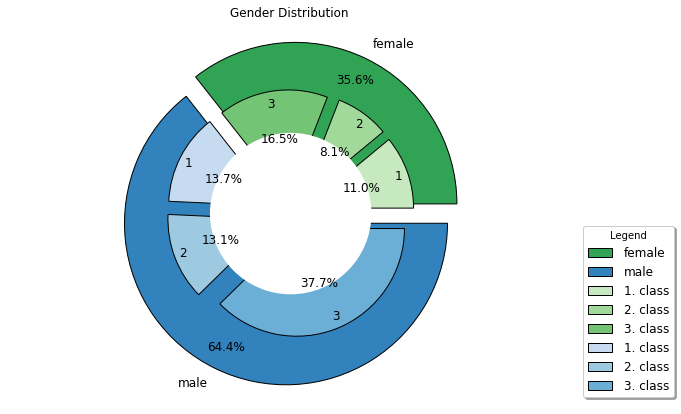

In [29]:
# Visualizing pie chart

fig, ax = plt.subplots(figsize=(10,7))

# Size and explsion
size_out = 3
size_in = 1
explode_out = (0.2,0.2)
explode_in = (0.3,0.3,0.3,0.3,0.3,0.3)

cmap = plt.get_cmap('tab20c')

outer_colors = cmap(np.array([8,0]))
inner_colors = cmap(np.array([11,10,9,3,2,1]))

patches1, texts1, autotexts1 = ax.pie(df_all.groupby(['Sex']).count().Name, radius=3, colors=outer_colors,
       labels=df_all.groupby(['Sex']).count().Name.index,autopct='%1.1f%%',pctdistance=0.85,
       wedgeprops=dict(width=size_out, edgecolor='black'),
       explode = explode_out)

patches2, texts2, autotexts2 = ax.pie(df_all.groupby(['Sex','Pclass']).count().Name, radius=2, colors=inner_colors,
       labels=[1,2,3,1,2,3],autopct='%1.1f%%', labeldistance=0.88,pctdistance=0.55,
       wedgeprops=dict(width=size_in, edgecolor='black'),
      explode = explode_in)

# Centre Cirle
centre_circle = plt.Circle((0,0),1.5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

#plt.rcParams['font.size'] = 10.0
#plt.rc_context


# Define the labels on the outer plot
for t in texts1:
    t.set_size('large')
for t in autotexts1:
    t.set_size('large')
#autotexts1[0].set_color('y')


# Define the labels on the inner plot
for t in texts2:
    t.set_size('large')
for t in autotexts2:
    t.set_size('large')
#autotexts2[0].set_color('d')


# Setting legend
ax.legend(loc='lower right', bbox_to_anchor=(0.7, 0., 0.5, 0.5), shadow=1,title='Legend',
          handletextpad=1, labelspacing=0.5 , fontsize='12', labels=['female','male','1. class','2. class', '3. class','1. class','2. class', '3. class'])


ax.set(aspect="equal", title='Gender Distribution')
plt.axis('equal')
plt.show()

Here you can see the different gender distributions to the ticket classes 1 to 3.

## Age Distribution by Ticket Class
Now the age distribution per ticket class will be visualized to get a better overview about the ages in each ticket class.

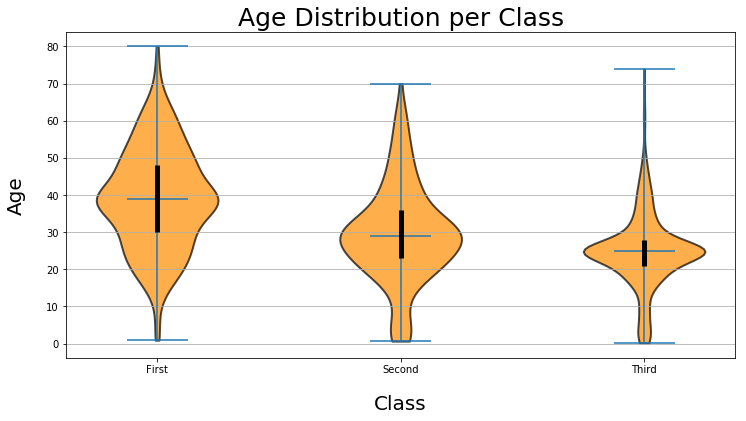

In [30]:
# Sclicing the three classes
df_firstclass_ages = df_all[df_all.loc[:,'Pclass'] == 1]['Age'].copy()
df_secondclass_ages = df_all[df_all.loc[:,'Pclass'] == 2]['Age'].copy()
df_thirdclass_ages = df_all[df_all.loc[:,'Pclass'] == 3]['Age'].copy()

# Combining all classes in an array
df_all_class_ages =[df_firstclass_ages.values,
                    df_secondclass_ages.values,
                    df_thirdclass_ages.values]

# Font dictionary
font = {'color':  'black',
        'weight': 'normal',
        'size': 18,
}

# Building the figure and the axes for the plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6) )

# plot violin plot
parts = axes.violinplot(df_all_class_ages
                   ,showmeans=False,
                    showmedians=True)
axes.set_title('Age Distribution per Class', fontdict=font, fontsize=25)

# Styling every violin in the graph
for pc in parts['bodies']:
    pc.set_facecolor('#FF8C00')
    pc.set_edgecolor('#000000')
    pc.set_linewidth(2)
    pc.set_alpha(0.7)


# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y + 1 for y in range(len(df_all_class_ages))])
axes.set_xlabel('Class',fontdict=font, labelpad=20, size=20)
axes.set_ylabel('Age', fontdict=font,labelpad=20, size=20)


axes.vlines(1, df_firstclass_ages.describe()['25%'], df_firstclass_ages.describe()['75%'], color=['#000000'], linestyle='-', lw=5)
axes.vlines(2, df_secondclass_ages.describe()['25%'], df_secondclass_ages.describe()['75%'], color=['#000000'], linestyle='-', lw=5)
axes.vlines(3, df_thirdclass_ages.describe()['25%'], df_thirdclass_ages.describe()['75%'], color=['#000000'], linestyle='-', lw=5)
#axes.vlines(2, whiskersMin, whiskersMax, color='k', linestyle='-', lw=1)

# add x-tick labels
plt.setp(axes, xticks=[y + 1 for y in range(len(df_all_class_ages))],
         xticklabels=['First', 'Second','Third'])


plt.show()

The first class has a wide range of passengers with a mean age of nearly 40. This looks different in the second class. The passengers have at least the same range of ages but the mean age here is more in the area of 30 years. The same is with third class but here is the age range not so high as with the other classes. It's even much smaller outside the mean age of 25. The most passengers in the third class are around 25 years old. 

## Salutation Distribution


In [31]:
# Grouping by and reset index
df_sal_distr = df_all.groupby('Salutation').count()
df_sal_distr.reset_index(level=0, inplace=True)
df_sal_distr = df_sal_distr[['Salutation','Pclass']]
#rename the column
df_sal_distr = df_sal_distr.rename(columns = {'Pclass':"Salutation_Count"})
                                              
df_sal_distr

,Salutation,Salutation_Count
0,Capt.,1
1,Col.,4
2,Countess.,1
3,Don.,1
4,Dona.,1
5,Dr.,8
6,Jonkheer.,1
7,Lady.,1
8,Major.,2
9,Master.,61


# Survivor Distribution
In this chapter, we will focus on the survivor distribution. In comparison to the **Feature Distribution** we will only focus on the training dataset because we only have valid survival information in this dataset. The training dataset only includes 891 and not 1309 as in the **Feature Distribution** chapter, therefore the distribution will look here slightly different.


## Male and Female Survivor
According to the distribution of 64.5% man and 35.6% women, we will now show the distribution of survivors broken down by gender. This distribution only shows the survival data for 891 passengers (from training data) and not for all ship passengers!


In [32]:
# The dataset with survived information
df_survivalinfo = pd.concat([df_all.loc[train_index,:], Survived], axis=1)

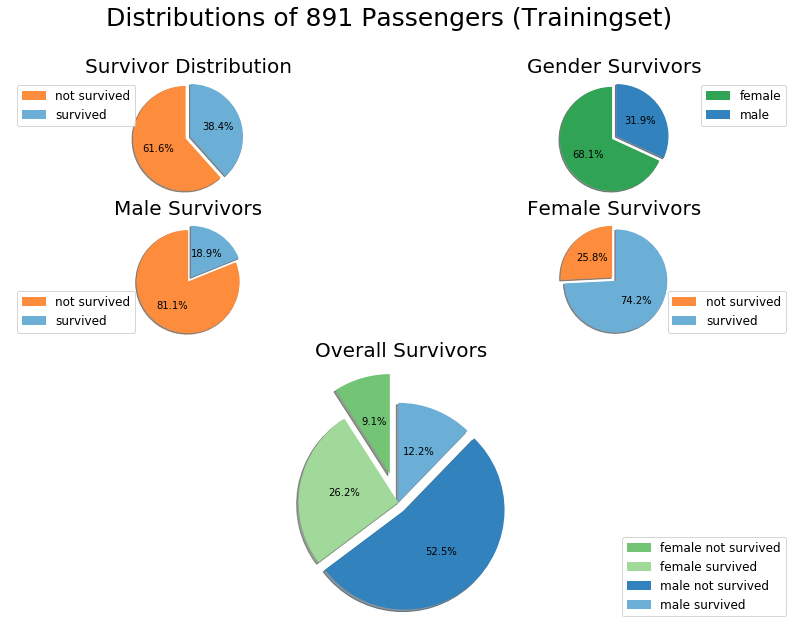

In [33]:
# Survival distribution per Sex
gp_survived_gender = df_survivalinfo.groupby(['Survived','Sex'])['Name'].count()[1]

# Gender Survival
gp_gender_survived = df_survivalinfo.groupby(['Sex','Survived']).count()['Name']

# Survival distribution Y/N 
gp_survived_yn = df_survivalinfo.groupby(['Survived']).agg('count')['Name']

# Survival total female / male 
gp_survival_total = df_survivalinfo.groupby(['Sex','Survived']).count().xs('Name', axis=1)


# Labels and size based on survival group by (df_survivalinfo)
#labels_suvinf = ['not suvived','survived']
sizes_suvinf = [gp_survived_yn[y] for y in range(len(gp_survived_yn))]
explode_suvinf = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

# Labels and size based on gender group by (gp_sex_survived)
labels_sexinf = [gp_survived_gender.index[y] for y in range(len(gp_survived_gender.index))]
sizes_sexinf = [gp_survived_gender[y] for y in range(len(gp_survived_gender))]
explode_sexinf = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

# Labels and size MALE Survivor Distribution
labels_maleinf = [gp_gender_survived['male'].index[y] for y in range(len(gp_gender_survived['male'].index))]
sizes_maleinf = [gp_gender_survived['male'][y] for y in range(len(gp_gender_survived['male']))]
explode_maleinf = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

# Labels and size FEMALE Survivor Distribution
labels_femaleinf = [gp_gender_survived['female'].index[y] for y in range(len(gp_gender_survived['female'].index))]
sizes_femaleinf = [gp_gender_survived['female'][y] for y in range(len(gp_gender_survived['female']))]
explode_femaleinf = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

# Labels and size total survival data
labels_totalsuvinf = [gp_survival_total.index[y] for y in range(len(gp_gender_survived.index))]
sizes_totalsuvinf = [gp_survival_total[y] for y in range(len(gp_survival_total))]
explode_totalsuvinf = (0.3, 0.0, 0.1, 0.0)  # not survived (fm), survived(fm), not survived(m), survived(m)


# Font dictionary
font = {'color':  'black',
        'weight': 'normal',
        #'size': 15,
        'fontsize':15
}

# Color maps for the pies
cmap = plt.get_cmap('tab20c')
survivedcolor = cmap(np.array([5,1]))
survivorallcolor = cmap(np.array([9,10,0,1]))

# Figure and axes of the plot / 4 * 2 plots 
gridsize = (4,2)
fig1 = plt.figure(figsize=(14,10))
ax1 = plt.subplot2grid(gridsize, (0,0))
ax2 = plt.subplot2grid(gridsize, (0,1))
ax3 = plt.subplot2grid(gridsize, (1,0))
ax4 = plt.subplot2grid(gridsize, (1,1))
ax5 = plt.subplot2grid(gridsize, (2,0), colspan= 2, rowspan= 2)

## fig1 configs
fig1.suptitle('Distributions of 891 Passengers (Trainingset)', fontsize=25)

## ax1 
# Define first pie for survival true falls
ax1.pie(sizes_suvinf, 
        explode=explode_suvinf,
        #labels=labels_suvinf,
        autopct='%1.1f%%',
        shadow=True, startangle=90,
        colors=survivedcolor,
        labeldistance=1.15,
        pctdistance=0.55
       )
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#ax1.fontdict=font
ax1.legend(loc='upper left',fontsize='12',labels=('not survived', 'survived'))
ax1.set_title('Survivor Distribution', fontdict=font, fontsize=20)

## ax2 
# Define second pie for sex to survival
ax2.pie(sizes_sexinf, 
        explode=explode_sexinf,
        #labels=labels_sexinf,
        autopct='%1.1f%%',
        shadow=True, startangle=90,
        colors=outer_colors,
        labeldistance=1.15,
        pctdistance=0.55)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#ax2.fontdict=font
ax2.legend(loc='upper right', fontsize='12', labels=labels_sexinf )
ax2.set_title('Gender Survivors', fontdict=font, fontsize=20)

ax3.pie(sizes_maleinf, 
        explode=explode_maleinf,
        #labels=labels_sexinf,
        autopct='%1.1f%%',
        shadow=True, startangle=90,
        colors=survivedcolor,
        labeldistance=1.15,
        pctdistance=0.55)
#ax3.fontdict=font
ax3.legend(loc='lower left', fontsize='12', labels=['not survived','survived'] )
ax3.set_title('Male Survivors', fontdict=font, fontsize=20)
ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


ax4.pie(sizes_femaleinf, 
        explode=explode_femaleinf,
        #labels=labels_sexinf,
        autopct='%1.1f%%',
        shadow=True, startangle=90,
        colors=survivedcolor,
        labeldistance=1.15,
        pctdistance=0.55)
#ax4.fontdict=font
ax4.legend(loc='lower right', fontsize='12', labels=['not survived','survived'] )
ax4.set_title('Female Survivors', fontdict=font, fontsize=20)
ax4.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


ax5.pie(sizes_totalsuvinf, 
        explode=explode_totalsuvinf,
        #labels=labels_totalsuvinf,
        autopct='%1.1f%%',
        shadow=True, startangle=90,
        colors=survivorallcolor,
        labeldistance=1.15,
        pctdistance=0.55)
ax5.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#ax4.fontdict=font
ax5.legend(loc='lower right', fontsize='12', labels=['female not survived','female survived','male not survived','male survived'] )
ax5.set_title('Overall Survivors', fontdict=font, fontsize=20)
ax5.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In the total of the 891 passengers, there are 62% that did not make it out of the tragedy and died in the open water.  The survivors are divided into 68.1% women and 31.9% man. It is clearly visible that a lot of female passengers have been rescued. If we look closer into the male passenger's data (third pie chart: "Male Survivors), 81% of the male passengers did not survive. In contrast, 74% of female passengers survived. 

The last pie in the middle shows an overall view of the female/male survival statistics.

## Distribution of  Ticket Class to Survival


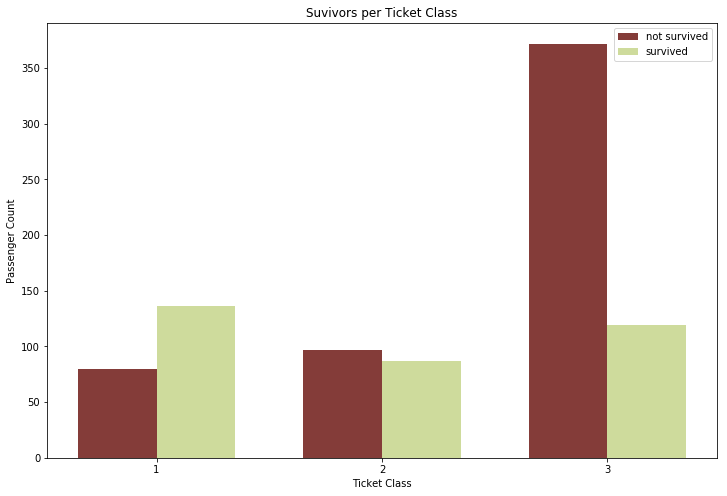

In [34]:
# Grouped by Survived and Pclass
gp_survpclass = df_survivalinfo.groupby(['Survived','Pclass'])['Name'].count()

gridsize = (1,2)
fig1 = plt.figure(figsize=(12,8))
ax1 = plt.subplot2grid(gridsize, (0,0), colspan=2, rowspan=1)

# Bar chart design
bar_width = 0.35
cmap = plt.get_cmap('tab20b')

survbarcol = cmap(np.array([7]))
nsurvbarcol = cmap(np.array([12]))

barindex = gp_survpclass[0].index   # Group by index of bar plot data
xtickslables = [barindex[y] for y in range(len(gp_survpclass[0].index))]



ax1.bar(barindex
        ,gp_survpclass[0].values
        ,bar_width
        ,color=nsurvbarcol
        )

ax1.bar(barindex + bar_width
        ,gp_survpclass[1].values
        ,bar_width
        ,color=survbarcol)

ax1.set_xlabel('Ticket Class')
ax1.set_ylabel('Passenger Count')
ax1.set_title('Suvivors per Ticket Class')
ax1.set_xticks(barindex + bar_width / 2)
ax1.set_xticklabels(xtickslables)
ax1.legend(labels=('not survived','survived'))

fig.tight_layout()
plt.show()

In [35]:
ptbl = pd.DataFrame.pivot_table(df_survivalinfo, values=['Fare', 'Survived'], index=['Pclass'],
                     aggfunc={'Survived': ['sum'], 'Fare': [min,max,np.mean]})

ptbl


Fare                 Survived
             max       mean  min      sum
Pclass                                   
1       512.3292  84.154687  0.0      136
2        73.5000  20.662183  0.0       87
3        69.5500  13.675550  0.0      119

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


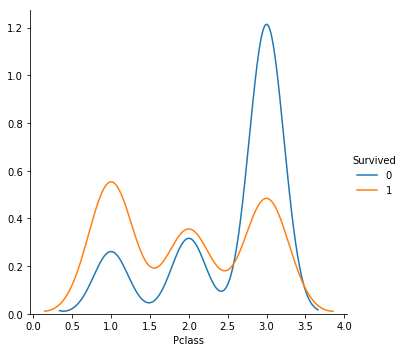

In [36]:
# seaborn's kdeplot, plots univariate or bivariate density estimates.
#Size can be changed by tweeking the value used
sns.FacetGrid(df_survivalinfo.loc[:,['Survived','Pclass']], hue="Survived", height=5).map(sns.kdeplot, "Pclass").add_legend()
plt.show()

## Survivors by Salutation

In [37]:
# Group by salutation and survival
df_survival_sal = df_survivalinfo.groupby(['Salutation','Survived'], as_index=False)['Name'].count()

# Rename column
df_survival_sal = df_survival_sal.rename(columns={"Name": "Total"})

# Aggregate/Count all Salutations
df_survival_sal_total = df_survival_sal.groupby('Salutation', as_index=False)['Total'].agg(sum)

# Not survived Salutations incl. renaming of Total column for join
df_survival_sal_nsuv = pd.DataFrame(df_survival_sal[df_survival_sal['Survived'] == 0])
df_survival_sal_nsuv = df_survival_sal_nsuv.rename(columns={'Total':'Total_notSurvived'})
df_survival_sal_nsuv = df_survival_sal_nsuv[['Salutation','Total_notSurvived']]


# Survived salutations incl. renaming of Total column for join
df_survival_sal_suv = pd.DataFrame(df_survival_sal[df_survival_sal['Survived'] == 1])
df_survival_sal_suv = df_survival_sal_suv.rename(columns={'Total':'Total_Survived'})
df_survival_sal_suv = df_survival_sal_suv[['Salutation','Total_Survived']]

# Joining all salutation survival information together
df_survival_sal_total = df_survival_sal_total.join(df_survival_sal_suv.set_index('Salutation'), on='Salutation', how='outer')
df_survival_sal_total = df_survival_sal_total.join(df_survival_sal_nsuv.set_index('Salutation'), on='Salutation', how='outer')

# Fill the NaN with zeros
df_survival_sal_total = df_survival_sal_total.fillna(value=0)

df_survival_sal_total

,Salutation,Total,Total_Survived,Total_notSurvived
0,Capt.,1,0.0,1.0
1,Col.,2,1.0,1.0
2,Countess.,1,1.0,0.0
3,Don.,1,0.0,1.0
4,Dr.,7,3.0,4.0
5,Jonkheer.,1,0.0,1.0
6,Lady.,1,1.0,0.0
7,Major.,2,1.0,1.0
8,Master.,40,23.0,17.0
9,Miss.,182,127.0,55.0


Here we see the distribution of the Salutation based on its total count and how its distribution according to the survived ones and not survived ones. This will partly be visualized in the following chart.

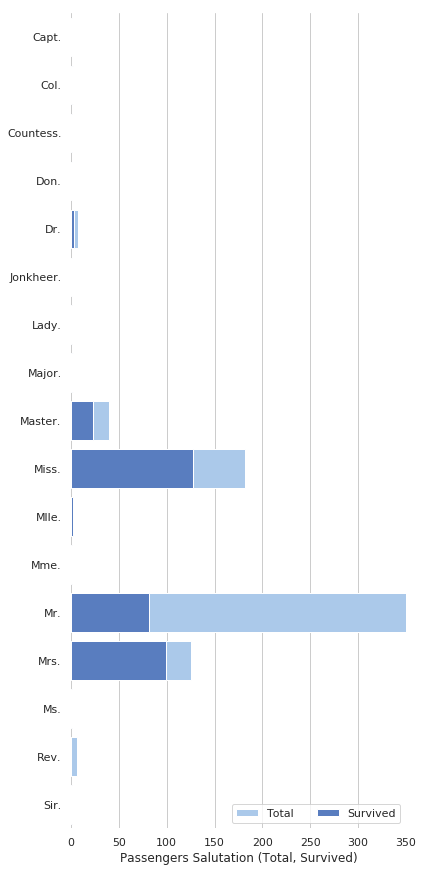

In [38]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Load the example car crash dataset
#crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)
salutations = df_survival_sal_total

# Plot the total salutations
sns.set_color_codes("pastel")
sns.barplot(x="Total", y="Salutation", data=salutations,
            label="Total", color="b")

## Plot the survivals
sns.set_color_codes("muted")
sns.barplot(x="Total_Survived", y="Salutation", data=salutations,
            label="Survived", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 350), ylabel="",
       xlabel="Passengers Salutation (Total, Survived)")
sns.despine(left=True, bottom=True)

We can see there are a lot of passengers with the salutation Mr/Mrs (of course), therefore the other ones look quite small or even barely visible through a bar. The light blue bars show the total amount of passengers for the salutation and the dark blue ones show the amount of surviving ones. The “Mr.” has got a lot of loss, the “Miss.” in comparison were luckier. If we look at the dark blue bars and compare “Mr.” and “Mrs.”, it seems there isn't much more “Mrs.” that survived than the “Mr.”. This is deceptive because not all "Mr." were actually counted for the "Mr." value. Think about "Dr." or "Rev.", these are all salutations that normally refer to the title "Mr.".

## Family Survival


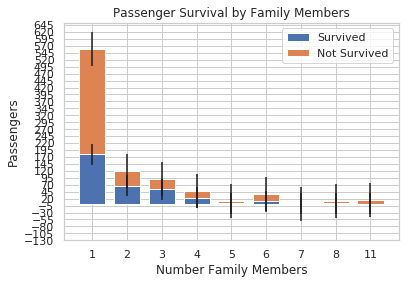

In [39]:
# Count of groupy
N = 9

# Group seperation by Survived Not-Survived
g_sur_Familymembers = df_survivalinfo[df_survivalinfo.loc[:,'Survived'] == 1].groupby('Number_of_Familymembers').count().Survived
g_nsur_Familymembers = df_survivalinfo[df_survivalinfo.loc[:,'Survived'] == 0].groupby('Number_of_Familymembers').count().Survived

sur_Std = g_sur_Familymembers.std(axis=0) 
sur_Mean = g_sur_Familymembers.mean(axis=0) 
nsur_Std = g_nsur_Familymembers.std(axis=0) 
nsur_Mean = g_nsur_Familymembers.mean(axis=0) 


# the x locations for the groups
ind  = np.arange(N)

width = 0.75       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, g_sur_Familymembers, width, yerr=sur_Mean)
p2 = plt.bar(ind, g_nsur_Familymembers, width,
             bottom=g_sur_Familymembers, yerr=nsur_Mean)


plt.ylabel('Passengers')
plt.xlabel('Number Family Members')
plt.title('Passenger Survival by Family Members')
plt.xticks(ind, ('1', '2', '3', '4', '5', '6', '7', '8', '11'))
plt.yticks(np.arange(-130, 670, 25))
plt.legend((p1[0], p2[0]), ('Survived', 'Not Survived'))

plt.show()

### Family Survivor by Familymember

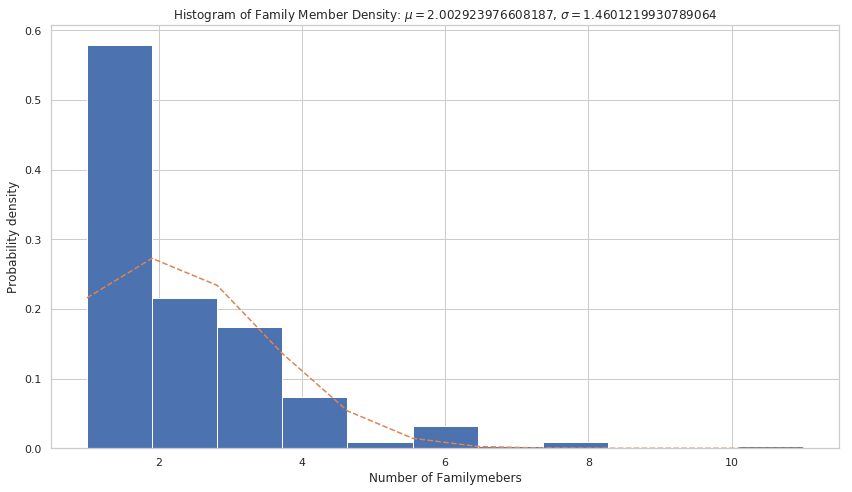

In [40]:
fammem_survived = df_survivalinfo['Number_of_Familymembers']
#[df_survivalinfo['Survived'] == 1]
#fare_survived = df_survivalinfo['Fare']

inputfeature = df_survivalinfo[df_survivalinfo['Survived'] == 1 ]['Number_of_Familymembers']

#df_survivalinfo['Number_of_Familymembers']

df_survivalinfo[df_survivalinfo['Survived'] == 1 ]

mu = inputfeature.describe()['mean']  # mean of distribution
sigma = inputfeature.describe()['std']  # standard deviation of distribution
x = mu + sigma * inputfeature.values

num_bins = 11

fig, ax = plt.subplots(figsize=(12,7))

# the histogram of the data
n, bins, patches = ax.hist(inputfeature,num_bins, density=1)

# add a 'best fit' line
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')
ax.set_xlabel('Number of Familymebers')
ax.set_ylabel('Probability density')
ax.set_title(r'Histogram of Family Member Density: $\mu='+ str(mu) +'$, $\sigma= $'+  str(sigma))

fig.tight_layout()
plt.show()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


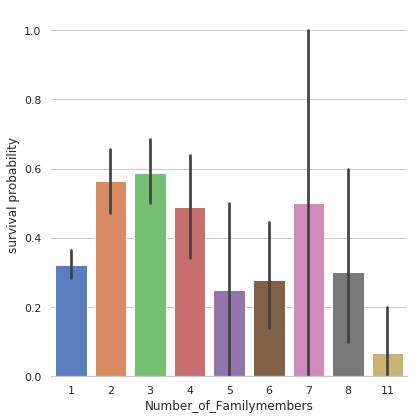

In [41]:
sns.set(style="whitegrid")

# Draw a nested barplot to show survival for class and sex
g = sns.catplot(x="Number_of_Familymembers", y="Survived", data=df_survivalinfo,
                #x="Pclass", y="Survived", hue='Number_of_Familymembers', data=df_survivalinfo,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")

## Gaussian Distrbution for Fare 

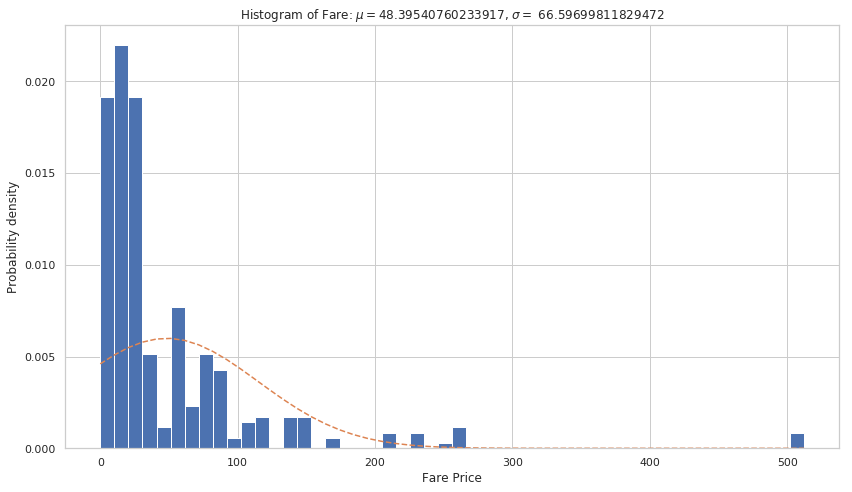

In [42]:
fare_survived = df_survivalinfo[df_survivalinfo['Survived'] == 1]['Fare']
#fare_survived = df_survivalinfo['Fare']

inputfeature = fare_survived

mu = inputfeature.describe()['mean']  # mean of distribution
sigma = inputfeature.describe()['std']  # standard deviation of distribution
x = mu + sigma * inputfeature.values

num_bins = 50

fig, ax = plt.subplots(figsize=(12,7))

# the histogram of the data
n, bins, patches = ax.hist(inputfeature,num_bins, density=1)

# add a 'best fit' line
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')
ax.set_xlabel('Fare Price')
ax.set_ylabel('Probability density')
ax.set_title(r'Histogram of Fare: $\mu=$'+ str(mu) +', $\sigma=$ ' + str(sigma))

fig.tight_layout()
plt.show()

## Survivor by Fare Price


In [43]:
# Pivot for age and fare
ptbl_survived = pd.DataFrame.pivot_table(df_survivalinfo, values=['Fare', 'Age', 'Survived'], index=['Sex', 'Pclass'],
                     aggfunc={'Fare': np.mean,'Age': [min, max, np.mean], 'Survived': ['sum']})
ptbl_survived

Age                         Fare Survived
                max       mean   min        mean      sum
Sex    Pclass                                            
female 1       63.0  35.031915  2.00  106.125798       91
       2       57.0  28.756579  2.00   21.970121       70
       3       63.0  22.697917  0.75   16.118810       72
male   1       80.0  40.888689  0.92   67.226127       45
       2       70.0  30.678981  0.67   19.741782       17
       3       74.0  26.099193  0.42   12.661633       47

## Overall Bivariate Relation

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


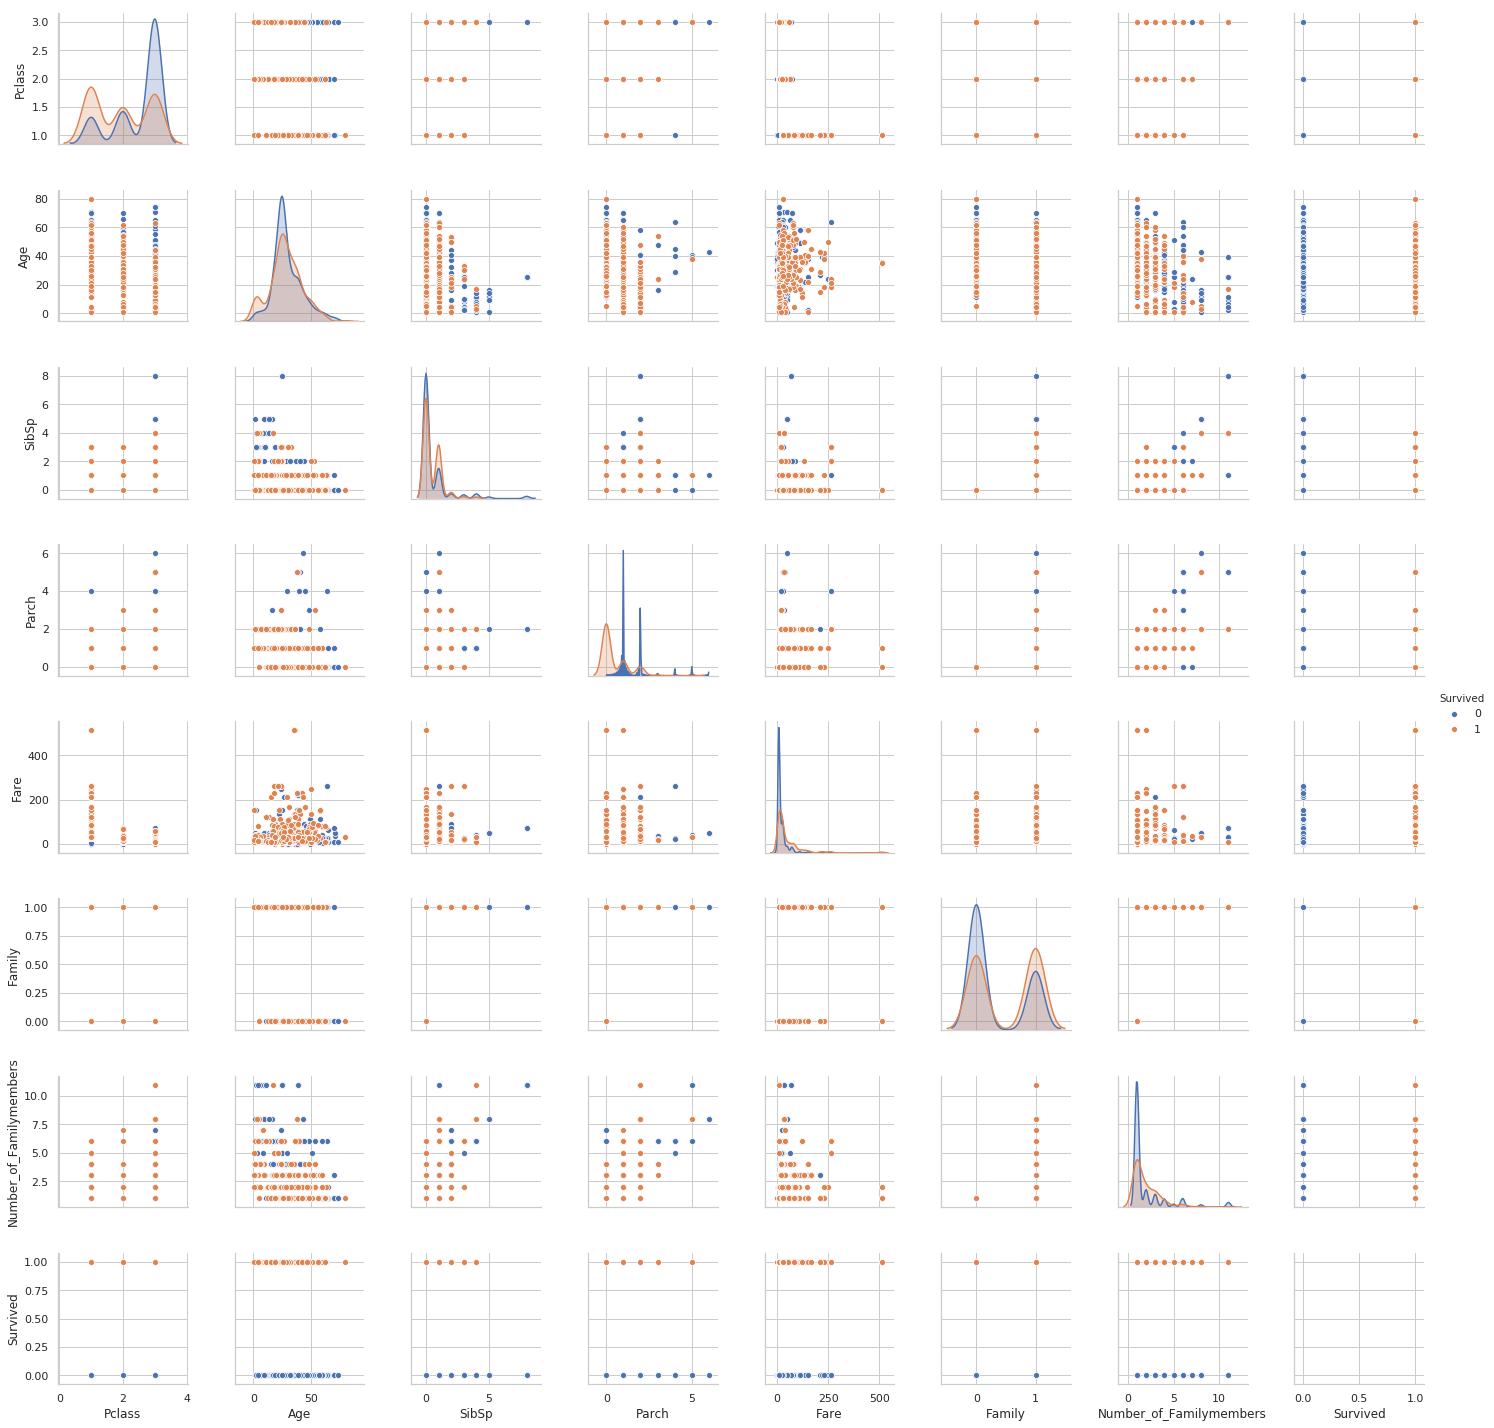

In [44]:
sns.pairplot(df_survivalinfo, hue='Survived')

# K-Nearest Neighbors based Model and Prediction
Based on the model improvement for the KNN, the following features will be dropped and therefore not included in the prediction:
- Name - **Cannot be used in this kind of model (KNN). **
- Cabin - **Not filled enough, too many null values.**
- Fare - **Do not lead to any further knowledge for the model.**
- Ticket - **Do not lead to any further knowledge  for the model.**

In [45]:
# K-Nearest Neighbours imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Using here the full dataset because train and test set must have the same shape when using it with model

# One hot encoding for the categorical data
df_all_knn_hot = df_all.copy()
df_all_knn_hot = df_all_knn_hot.drop(['Name','Cabin','Fare','Ticket','Lastname'], axis=1)
df_all_knn_hot = pd.get_dummies(df_all_knn_hot, columns=['Sex','Salutation','Embarked'])



# Train test split only on test dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_all_knn_hot.loc[train_index,:], 
                                                    Survived, test_size = 0.30, random_state = 45)  ## 50  25 ## 0.25 25 , 25

## Visualize the Best Model Fit for KNN

In [46]:
from sklearn.model_selection import cross_val_score

# creating odd list of K for KNN
myList = list(range(1,50))

# subsetting just the odd ones
neighbors = list(myList)


# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

The optimal number of neighbors is 5


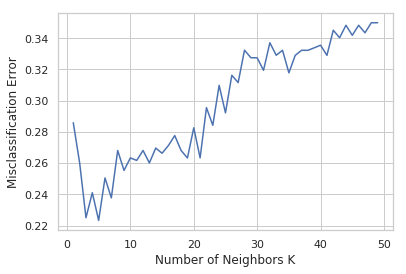

In [47]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print ("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

## Train the KNN
As shown in the previous figure, the best fit for neighbors seems to be 5. For the model training I will therefore use 5 neighbors. 

In [48]:
# K-Nearest Neighbours
from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix



X_train = X_train
y_train = y_train

# 3 Neighbors used from the misclassification error calculation
KNNC = KNeighborsClassifier(n_neighbors=3)
KNNC.fit(X_train, y_train)

y_pred = KNNC.predict(X_test)

# Summary of the predictions made by the classifier
print(classification_report(y_test, y_pred, target_names=['0','1']))


print ("Models accuracy score: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       178
           1       0.76      0.72      0.74        90

   micro avg       0.83      0.83      0.83       268
   macro avg       0.81      0.80      0.81       268
weighted avg       0.83      0.83      0.83       268

Models accuracy score:  0.8283582089552238


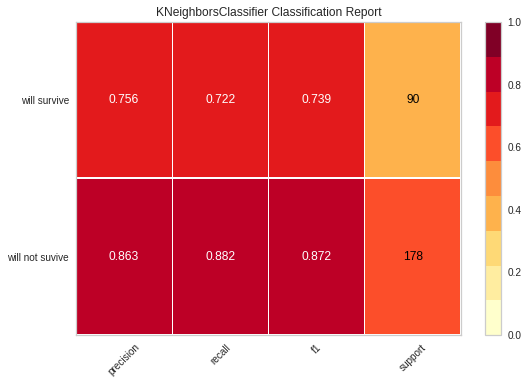

In [49]:
from yellowbrick.classifier import ClassificationReport

classes = ["will not suvive", "will survive"]

# Instantiate the classification model and visualizer
visualizer = ClassificationReport(KNNC, classes=classes, support=True)

visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

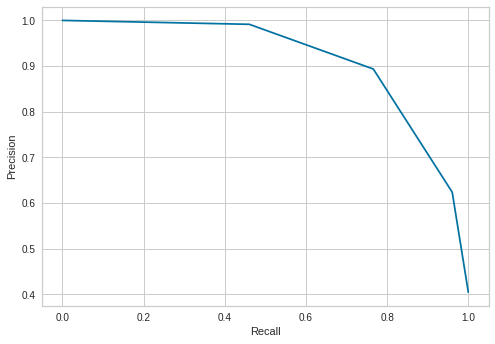

In [50]:
# Plotting the Precision-Recall curve
y_proba_train = KNNC.predict_proba(X_train)[:, 1]
p, r, t = metrics.precision_recall_curve(y_train, y_proba_train)

plt.plot(r, p)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

## Execution on Testset with KNN

In [51]:
titanic_submission = pd.DataFrame({'PassengerId':df_all_knn_hot.loc[test_index,:].index,
                                   'Survived':KNNC.predict(df_all_knn_hot.loc[test_index,:])})
titanic_submission.PassengerId = titanic_submission.PassengerId.astype(int)
titanic_submission.Survived = titanic_submission.Survived.astype(int)

# Overview how much suvived with k-nearest neighbor approach
titanic_submission.groupby('Survived').count()

,PassengerId
Survived,
0,269
1,149


In [52]:
titanic_submission.head(15)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1
5,897,0
6,898,1
7,899,0
8,900,0
9,901,0


Here you see an overview about the prediction on the test dataset.

In [53]:
# Submission to a csv file for competition upload.
titanic_submission.to_csv("titanic_submission_knn_4.csv", index=False)

# Random Forest based Model and Prediction 


In [54]:
# Random Forest imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier


# Using here the full dataset because train and test set must have the same shape when using it with model

# One hot encoding for the categorical data
df_all_rf_hot = df_all.copy()
df_all_rf_hot = df_all_rf_hot.drop(['Name','Cabin','Fare','Ticket','Lastname'], axis=1)
df_all_rf_hot = pd.get_dummies(df_all_rf_hot, columns=['Sex','Salutation','Embarked'])



# Train test split only on test dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_all_rf_hot.loc[train_index,:], 
                                                    Survived, test_size = 0.30, random_state = 45)  ## 50  25 ## 0.25 25 , 25

## Visualize the Best Model Fit for RFC

In [55]:
from sklearn.model_selection import cross_val_score

# creating odd list of K for KNN 
myList = list(range(1,30))

# subsetting just the odd ones
levels = list(myList)


# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for l in levels:
    rfc = RandomForestClassifier( n_estimators=100)
    scores = cross_val_score(rfc, X_train, y_train, cv=5, scoring='recall')
    cv_scores.append(scores.mean())

The optimal level depth is 3


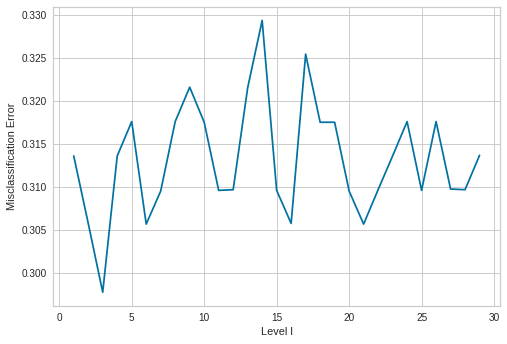

In [56]:
# changing to misclassification error 
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_l = levels[MSE.index(min(MSE))]
print ("The optimal level depth is %d" % optimal_l)

# plot misclassification error vs k
plt.plot(levels, MSE)
plt.xlabel('Level l')
plt.ylabel('Misclassification Error')
plt.show()

## Train the Random Forest
As shown in the previous figure, the best fit for neighbors seems to be 5. For the model training I will therefore use 5 neighbors. 

In [57]:
# K-Nearest Neighbours
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.tree import DecisionTreeClassifier




X_train = X_train
y_train = y_train

# Random forest classifier  
RFCC = RandomForestClassifier(max_depth=14,
                              n_estimators=5000)
#RFCC = RandomForestClassifier(n_estimators=1000)
RFCC.fit(X_train, y_train)

y_pred = RFCC.predict(X_test)

# Summary of the predictions made by the classifier
print(classification_report(y_test, y_pred, target_names=['0','1']))


print ("Models accuracy score: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       178
           1       0.73      0.80      0.76        90

   micro avg       0.83      0.83      0.83       268
   macro avg       0.81      0.82      0.82       268
weighted avg       0.84      0.83      0.83       268

Models accuracy score:  0.832089552238806


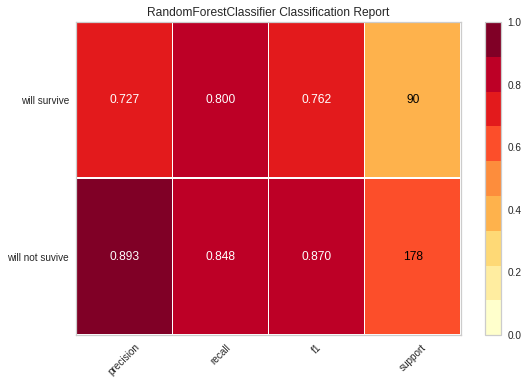

In [58]:
from yellowbrick.classifier import ClassificationReport

classes = ["will not suvive", "will survive"]

# Instantiate the classification model and visualizer
visualizer = ClassificationReport(RFCC, classes=classes, support=True)

visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

## Execution on Testset with Random Forest

In [59]:
titanic_submission_rfc = pd.DataFrame({'PassengerId':df_all_rf_hot.loc[test_index,:].index,
                                   'Survived':RFCC.predict(df_all_rf_hot.loc[test_index,:])})
titanic_submission_rfc.PassengerId = titanic_submission_rfc.PassengerId.astype(int)
titanic_submission_rfc.Survived = titanic_submission_rfc.Survived.astype(int)

# Overview how much suvived with random forest approach
titanic_submission_rfc.groupby('Survived').count()

,PassengerId
Survived,
0,234
1,184


In [60]:
# Submission to a csv file for competition upload.
titanic_submission_rfc.to_csv("titanic_submission_rfc_5.csv", index=False)

# Neural Network based Model and Prediction

Neural Network Approach to Indicate the Survivors
In this chapter, I will use a neural network to predict the survivors. Therefore I will start with the classic approach and the sigmoid function. 

In [61]:
# importing sigmoid function
import scipy.special


## Neural Network Classdefinition

In [62]:
# Neural network class definition

class neuralNetwork:
    
    # Initialize
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        # Number of nodes in each layer
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        
        # Bulding the size of the weight matrices without normal distribution info
        ## self.wih = (np.random.rand(self.hnodes,self.inodes) - 0.5)
        ## self.who = (np.random.rand(self.onodes,self.hnodes) - 0.5)
        
        # Size of the weight matrice by random sample based on the normal distribution
        self.wih = np.random.normal(0.0, pow(self.hnodes, -0.5), (self.hnodes, self.inodes))
        self.who = np.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.hnodes))
        
        #self.whh = np.random.normal(0.0, pow(self.hnodes, -0.5), (self.hnodes, self.inodes))
        
        self.lrate = learningrate
        
        self.activationfunction = lambda x : scipy.special.expit(x);
        
        pass 
    
    def train(self, inputlist, targetlist):
        inputs = np.array(inputlist, ndmin=2).T
        targets = np.array(targetlist, ndmin=2).T
        
        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.activationfunction(hidden_inputs)
        
        # hidden layer 2
        #hidden2_inputs = np.dot(self.wih, inputs)
        #hidden2_outputs = self.activationfunction(hidden_inputs)
            
            
        final_inputs = np.dot(self.who, hidden_outputs)
        final_outputs = self.activationfunction(final_inputs)
        
        
        ## BACKPROPAGATION ##
        
        output_errors = targets - final_outputs
        
        hidden_errors = np.dot(self.who.T, output_errors)
        
        self.who += self.lrate * np.dot((output_errors * final_outputs * (1 - final_outputs)), np.transpose(hidden_outputs))        
        
        self.wih += self.lrate * np.dot((hidden_errors * hidden_outputs * (1 - hidden_outputs)), np.transpose(inputs))
        
        pass
    
    def query(self, inputs_list):
        inputs = np.array(inputs_list, ndmin = 2).T
        
        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.activationfunction(hidden_inputs)
        
        final_inputs = np.dot(self.who, hidden_outputs)
        final_outputs = self.activationfunction(final_inputs)
        
        return final_outputs

In [63]:
# List to record the different configurations
# The idea is to store: nn_accuracy,learningrate,hidden_nodes,epochs
conf_performance_list = []


## Initialize Neural Network

In [64]:
# Main configuration params for the nn
input_nodes = 29
hidden_nodes = 3
output_nodes = 2

learningrate = 0.4
nn_epochs = 1000     #453000   #49000

In [65]:
# Initialize neural network for titanic passengers
titanic_nn = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learningrate)

## Train Neural Network
In this training chapter, I will first train the model with 75% of the training set and use the remaining 15% to test the results and adjust the configurations (learningrate, hiddenlayer nodes, epochs to train). Right after that, I will train the model again with the remaining 15% of the training data. I do this to hand over the model as much data as possible to predict on the real testset (the testset for the submission) as good as possible.

### Train Model 75/15

In [66]:
# train test split ( this function makes it very easy to split the data by percentage) 
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(df_all_knn_hot.loc[train_index,:], Survived, test_size = 0.15, random_state = 45) 

In [67]:
# Prepare data for learning
# To make everything easier the X_train and the y_train (targets) will be 
# combined in one df again to loop over it easier.

Xy_train_nn = pd.concat([X_train_nn, y_train_nn], axis=1)

In [68]:
# train the nn multiple (epochs) times.
epochs = nn_epochs


for e in range(epochs):
    
    for row in Xy_train_nn.itertuples():
        
        inputs = (np.asfarray(row[1:30]) / 29 * 0.99) + 0.01
               
        targets = np.zeros(output_nodes) + 0.01
        targets[int(row[30])] = 0.99
             
        titanic_nn.train(inputs, targets)
        
        pass
    pass

    

### Test Model 75/15
Now the remaining 15% will be used to test and adjust the model by its configurations.

In [69]:
# concatenate test set
Xy_test_nn = pd.concat([X_test_nn, y_test_nn], axis=1)

In [70]:
testrowindex = 2

#retrieving the results
nn_result = titanic_nn.query(Xy_test_nn[Xy_test_nn.columns[0:29]].values[testrowindex])

#### Scorecard Model 75/15
In the following there will be build a scorecard to check whether the neural network has predicted the results correctly or not, this will be realized by a simple true/false sign (1/0)

In [71]:
# List to store the true and false prediction results of the nn
scorecard = []
# List to store the matrix structure results to analyse it afterwards
matrixlist = []

for index,row in Xy_test_nn.iterrows():
    
    inputs = row[0:29].values
    
    correct_label = row[29]
    
    results = titanic_nn.query(inputs)
    
    label = np.argmax(results)
    
    print('PassengerID:', index, ' - Networks answer: ', label, ' --> Correct answer: ', correct_label)
    
    # Append all information to this list to get an overview about networks results and its matrix structure.
    matrixlist.append([results, label, correct_label])

    
    if(label == correct_label):
        scorecard.append(1)
    else:
        scorecard.append(0)
    pass     
        

PassengerID: 249  - Networks answer:  0  --> Correct answer:  1.0
PassengerID: 198  - Networks answer:  0  --> Correct answer:  0.0
PassengerID: 134  - Networks answer:  0  --> Correct answer:  1.0
PassengerID: 170  - Networks answer:  0  --> Correct answer:  0.0
PassengerID: 737  - Networks answer:  0  --> Correct answer:  0.0
PassengerID: 167  - Networks answer:  1  --> Correct answer:  1.0
PassengerID: 251  - Networks answer:  0  --> Correct answer:  0.0
PassengerID: 720  - Networks answer:  0  --> Correct answer:  0.0
PassengerID: 604  - Networks answer:  0  --> Correct answer:  0.0
PassengerID: 472  - Networks answer:  0  --> Correct answer:  0.0
PassengerID: 683  - Networks answer:  0  --> Correct answer:  0.0
PassengerID: 834  - Networks answer:  0  --> Correct answer:  0.0
PassengerID: 583  - Networks answer:  0  --> Correct answer:  0.0
PassengerID: 400  - Networks answer:  0  --> Correct answer:  1.0
PassengerID: 409  - Networks answer:  0  --> Correct answer:  0.0
PassengerI

In [72]:
scorecard_array = np.array(scorecard)
nn_accuracy = scorecard_array.sum() / scorecard_array.size

# Append current network settings to a list 
#   due to several runs of the network I will store here all configurations and 
#   its corresponding accuracy to adjust the model better.
conf_performance_list.append([nn_accuracy,learningrate,hidden_nodes,epochs])

print('Accuracy score by "75/15"-network: ', nn_accuracy)

Accuracy score by "75/15"-network:  0.7388059701492538


In [73]:
# Configurations performance list
#   This list is used to show the different configuration in comparision to the accuracy to fine tune the nn
#   It will be commented out after I have found out the best fit
#   Columns: nn_accuracy,learningrate,hidden_nodes,epochs

# conf_performance_list

### Train with Remaining Data (75)/15
This part here will train the model with the remaining 15% from our train/test split. The idea behind it is to give the model as much data as possible.

In [74]:
# train the nn multiple (epochs) times.
epochs = nn_epochs


for e in range(epochs):
    
    for row in Xy_test_nn.itertuples():
        
        inputs = (np.asfarray(row[1:30]) / 29 * 0.99) + 0.01        
        targets = np.zeros(output_nodes) + 0.01
        targets[int(row[30])] = 0.99
  
        titanic_nn.train(inputs, targets)
        
        pass
    pass

## Execution on Testset with Neural Network
The trained neural network will now be executed on the Titanic testset to create a submission file afterwards.

In [75]:
titanic_submission_nn = pd.DataFrame(columns=['PassengerId','Survived'])

for index,row in df_all_rf_hot.loc[test_index].iterrows():
    
    inputs = row[0:29].values
    
    results = titanic_nn.query(inputs)
    
    label = np.argmax(results)
        
    titanic_submission_nn = titanic_submission_nn.append({'PassengerId' : index , 'Survived': label} , ignore_index=True)
        
    pass

In [76]:
# Preparing the submission file
titanic_submission_nn.PassengerId = titanic_submission_nn.PassengerId.astype(int)
titanic_submission_nn.Survived = titanic_submission_nn.Survived.astype(int)

titanic_submission_nn.groupby('Survived').count()

,PassengerId
Survived,
0,361
1,57


In [77]:
titanic_submission_nn.to_csv("titanic_submission_nn_6.csv", index=False)

# Neural Network with Tensorflow

In [78]:
import tensorflow as tf

In [79]:
# train test split ( this function makes it very easy to split the data by percentage) 
X_train_tfnn, X_test_tfnn, y_train_tfnn, y_test_tfnn = train_test_split(df_all_knn_hot.loc[train_index,:], Survived, test_size = 0.15, random_state = 45) 

# scale the values between 0 and 1
X_train_tfnn = tf.keras.utils.normalize(np.asfarray(X_train_tfnn),axis= -1)
X_test_tfnn = tf.keras.utils.normalize(np.asfarray(X_test_tfnn),axis= -1)

y_train_tfnn = np.asfarray(y_train_tfnn) 
y_test_tfnn = np.asfarray(y_test_tfnn) 

In [80]:
# Model building
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
            )
model.fit(X_train_tfnn, y_train_tfnn, epochs = 200)

Instructions for updating:
Colocations handled automatically by placer.
Epoch 1/200
757/757 [==============================] - 0s 369us/sample - loss: 0.6690 - acc: 0.6037
Epoch 2/200
757/757 [==============================] - 0s 65us/sample - loss: 0.6488 - acc: 0.6314
Epoch 3/200
757/757 [==============================] - 0s 78us/sample - loss: 0.6292 - acc: 0.6380
Epoch 4/200
757/757 [==============================] - 0s 78us/sample - loss: 0.6146 - acc: 0.6711
Epoch 5/200
757/757 [==============================] - 0s 76us/sample - loss: 0.5869 - acc: 0.7001
Epoch 6/200
757/757 [==============================] - 0s 85us/sample - loss: 0.5400 - acc: 0.7728
Epoch 7/200
757/757 [==============================] - 0s 73us/sample - loss: 0.5089 - acc: 0.7979
Epoch 8/200
757/757 [==============================] - 0s 70us/sample - loss: 0.4984 - acc: 0.7926
Epoch 9/200
757/757 [==============================] - 0s 67us/sample - loss: 0.4821 - acc: 0.7979
Epoch 10/200
757/757 [==============

In [81]:
# Test the model and show the accuracy
val_loss, val_acc = model.evaluate(X_test_tfnn, y_test_tfnn)

134/134 [==============================] - 0s 458us/sample - loss: 0.4076 - acc: 0.8881


In [82]:
# Save the model so far
model.save('titanic_survivor_predictor.model')

In [83]:
# Load the model again
new_model = tf.keras.models.load_model('titanic_survivor_predictor.model')